# [Advent of Code 2019: Day 11](https://adventofcode.com/2019/day/11)

<h2>--- Day 11: Space Police ---</h2>
<p>On the way to Jupiter, you're <a href="https://www.youtube.com/watch?v=KwY28rpyKDE">pulled over</a> by the <em>Space Police</em>.</p>
<p>"Attention, unmarked spacecraft! You are in violation of Space Law! All spacecraft must have a clearly visible <em>registration identifier</em>! You have 24 hours to comply or be sent to <a href="https://www.youtube.com/watch?v=BVn1oQL9sWg&amp;t=5">Space Jail</a>!"</p>
<p>Not wanting to be sent to Space Jail, you radio back to the Elves on Earth for help. Although it takes almost three hours for their reply signal to reach you, they send instructions for how to power up the <em>emergency hull painting robot</em> and even
    provide a small <a href="https://adventofcode.com/2019/day/9">Intcode program</a> (your puzzle input) that will cause it to paint your ship appropriately.</p>
<p>There's just one problem: you don't have an emergency hull painting robot.</p>
<p>You'll need to build a new emergency hull painting robot. The robot needs to be able to move around on the grid of square panels on the side of your ship, detect the color of its current panel, and paint its current panel <em>black</em> or <em>white</em>.
    (All of the panels are currently <em>black</em>.)</p>
<p>The Intcode program will serve as the brain of the robot. The program uses input instructions to access the robot's camera: provide <code>0</code> if the robot is over a <em>black</em> panel or <code>1</code> if the robot is over a <em>white</em> panel.
    Then, the program will output two values:</p>
<ul>
    <li>First, it will output a value indicating the <em>color to paint the panel</em> the robot is over: <code>0</code> means to paint the panel <em>black</em>, and <code>1</code> means to paint the panel <em>white</em>.</li>
    <li>Second, it will output a value indicating the <em>direction the robot should turn</em>: <code>0</code> means it should turn <em>left 90 degrees</em>, and <code>1</code> means it should turn <em>right 90 degrees</em>.</li>
</ul>
<p>After the robot turns, it should always move <em>forward exactly one panel</em>. The robot starts facing <em>up</em>.</p>
<p>The robot will continue running for a while like this and halt when it is finished drawing. Do not restart the Intcode computer inside the robot during this process.</p>
<p>For example, suppose the robot is about to start running. Drawing black panels as <code>.</code>, white panels as <code>#</code>, and the robot pointing the direction it is facing (<code>&lt; ^ &gt; v</code>), the initial state and region near the robot
    looks like this:</p>
<pre><code>.....
.....
..^..
.....
.....
</code></pre>
<p>The panel under the robot (not visible here because a <code>^</code> is shown instead) is also black, and so any input instructions at this point should be provided <code>0</code>. Suppose the robot eventually outputs <code>1</code> (paint white) and
    then <code>0</code> (turn left). After taking these actions and moving forward one panel, the region now looks like this:</p>
<pre><code>.....
.....
.&lt;#..
.....
.....
</code></pre>
<p>Input instructions should still be provided <code>0</code>. Next, the robot might output <code>0</code> (paint black) and then <code>0</code> (turn left):</p>
<pre><code>.....
.....
..#..
.v...
.....
</code></pre>
<p>After more outputs (<code>1,0</code>, <code>1,0</code>):</p>
<pre><code>.....
.....
..^..
.##..
.....
</code></pre>
<p>The robot is now back where it started, but because it is now on a white panel, input instructions should be provided <code>1</code>. After several more outputs (<code>0,1</code>, <code>1,0</code>, <code>1,0</code>), the area looks like this:</p>
<pre><code>.....
..&lt;#.
...#.
.##..
.....
</code></pre>
<p>Before you deploy the robot, you should probably have an estimate of the area it will cover: specifically, you need to know the <em>number of panels it paints at least once</em>, regardless of color. In the example above, the robot painted <em><code>6</code> panels</em>    at least once. (It painted its starting panel twice, but that panel is <a href="https://www.youtube.com/watch?v=KjsSvjA5TuE">still only counted once</a>; it also never painted the panel it ended on.)</p>
<p>Build a new emergency hull painting robot and run the Intcode program on it. <em>How many panels does it paint at least once?</em></p>

In [1]:
import os
import unittest
import numpy as np
from matplotlib import pyplot as plt
from intcode import IntcodeComputer

class HullPaintingRobot():
    
    BLACK = 0
    WHITE = 1

    MOVE_LEFT  = 0
    MOVE_RIGHT = 1
    
    DIR_UP    = 0
    DIR_RIGHT = 1
    DIR_DOWN  = 2
    DIR_LEFT  = 3
    DIR_COUNT = 4
    
    FINISHED = 0
    RUNNING = 1
    ERROR = -1
    
    def __init__(self, program):
        self.iccp = IntcodeComputer(program)
        self.paint_count = 0
        self.move_count = 0
        self.paint_data = {}
        self.position = (0,0,self.DIR_UP)
    
    def move(self, move_dir):
        x,y,fd = self.position
        
        if move_dir == self.MOVE_LEFT:
            fd = (fd-1) % self.DIR_COUNT
        elif move_dir == self.MOVE_RIGHT:
            fd = (fd+1) % self.DIR_COUNT
        else:
            raise Exception(f'Cannot move in unkown direction: {move_dir}')
            
        if fd == self.DIR_UP:
            y += 1
        elif fd == self.DIR_RIGHT:
            x += 1
        elif fd == self.DIR_DOWN:
            y -= 1
        elif fd == self.DIR_LEFT:
            x -= 1
        else:
            raise Exception(f'Cannot move, unkown facing direction: {fd}')
        
        self.position = (x, y, fd)
        self.move_count += 1
            
    def get_coord_position(self):
        x,y,d = self.position
        return (x,y)
    
    def paint(self, color):
        if color not in [self.WHITE, self.BLACK]:
            raise Exception(f'Cannot paint unknown color: {color}')
        
        coord_pos = self.get_coord_position()
        self.paint_data[coord_pos] = color
            
        self.paint_count += 1
            
    def get_camera_color(self):
        coord_pos = self.get_coord_position()
        return self.paint_data.setdefault(coord_pos, self.BLACK)
        
    def plot_data(self):
        # Getting information to build an image array
        img_x, img_y =  list(zip(*self.paint_data.keys()))        
        x_offset = abs(min(img_x))
        y_offset = abs(min(img_y))
        
        #I'm not sure why but we need to flip the x and y
        img = np.zeros([max(img_y)+y_offset+1, max(img_x)+x_offset+1])
        for x, y in self.paint_data:
            img[y+y_offset,x+x_offset] = self.paint_data[x,y]

        plt.imshow(img, cmap='binary')
        plt.gca().invert_yaxis()
        plt.show()
                
    def reset(self):
        self.iccp.reset()
        self.paint_count = 0
        self.paint_data = {}
        self.position = (0,0,self.DIR_UP)
        
    def start(self, start_color, verbose = False):
        self.iccp.add_input(start_color)
        while True:
            self.iccp.run()            
            # First output is the color to paint at the current position
            color_to_paint = self.iccp.output            
            if color_to_paint == None:
                break                
            self.paint(color_to_paint)
            
            self.iccp.run()            
            # Second output is the direction to move
            move_dir = self.iccp.output
            if move_dir == None:
                break
            self.move(move_dir)
            
            self.iccp.add_input(self.get_camera_color())
        print(f'Painted panels: {len(self.paint_data.keys())}')
            
class TestHullPaintingRobot(unittest.TestCase):
    def test_move(self):
        robot_program = "99"
        hbot = HullPaintingRobot(robot_program)
                 
        data = [(None,(0,0,hbot.DIR_UP)),
                (hbot.MOVE_RIGHT, (1,0,hbot.DIR_RIGHT)),
                (hbot.MOVE_LEFT, (1,1,hbot.DIR_UP)),
                (hbot.MOVE_RIGHT, (2,1,hbot.DIR_RIGHT)),
                (hbot.MOVE_RIGHT, (2,0,hbot.DIR_DOWN)),
                (hbot.MOVE_RIGHT, (1,0,hbot.DIR_LEFT)),
                (hbot.MOVE_RIGHT, (1,1,hbot.DIR_UP)),
                (hbot.MOVE_LEFT, (0,1,hbot.DIR_LEFT))]
        
        for move, result in data:
            if move != None:
                hbot.move(move)
            self.assertEqual(hbot.position, result)        
            
unittest.main(argv=[""], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


Painted panels: 1883


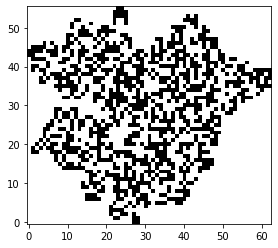

In [2]:
with open("inputs/input_d11.txt") as file:
    robot_program = file.read()

hbot = HullPaintingRobot(robot_program)
hbot.start(hbot.BLACK)
hbot.plot_data()

<h2 id="part2">--- Part Two ---</h2>
<p>You're not sure what it's trying to paint, but it's definitely not a <em>registration identifier</em>. The Space Police are getting impatient.</p>
<p>Checking your external ship cameras again, you notice a white panel marked "emergency hull painting robot starting panel". The rest of the panels are <em>still black</em>, but it looks like the robot was expecting to <em>start on a white panel</em>, not
    a black one.</p>
<p>Based on the <span title="Just be glad it wasn't a full set of Space Law Space Books; the number of pages is *astronomical*.">Space Law Space Brochure</span> that the Space Police attached to one of your windows, a valid registration identifier is always
    <em>eight capital letters</em>. After starting the robot on a single <em>white panel</em> instead, <em>what registration identifier does it paint</em> on your hull?</p>

Painted panels: 250


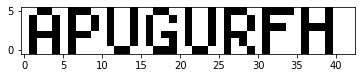

In [3]:
hbot.reset()
hbot.start(hbot.WHITE)
hbot.plot_data()